In [54]:
import gc
gc.collect()

326

In [1]:
import numpy as np
import skimage.measure
# import pydicom
import os
import matplotlib.pyplot as plt
import cv2
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.data import Dataset
from tensorflow.examples.tensorflow_examples.models.pix2pix import pix2pix
from IPython.display import clear_output
import matplotlib.pyplot as plt
from keras import backend as K
import keras

In [2]:
# plt.gray()
os.chdir('C:/Users/span/Documents/CNN/')

In [3]:
# load for countinue trainning
model = tf.keras.models.load_model('03_model/Model_tensflow.ep20_23.32.33.h5')

In [4]:
number3 = 33
subfolder3 = str(number3) + "_prepro"

path5 = "01_perprocess/"+str(number3)+"/"+subfolder3

In [5]:
def read_image1(img_path: str) -> dict:
    image = tf.io.read_file(img_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.uint8)
    return {'image': image}

In [6]:
# from run
SEED = 1024

batch_size = 16
target_size=(256, 256)

dataset0 = tf.data.Dataset.list_files(path5+"/*.png", seed=SEED, shuffle=False)
dataset0 = dataset0.map(read_image1)

In [7]:
@tf.function
def normalize(input_image: tf.Tensor) -> tuple:
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image

@tf.function
def load_image_pre(datapoint: dict) -> tuple:
    input_image = tf.image.resize(datapoint['image'], (IMG_SIZE, IMG_SIZE))
    
    input_image = normalize(input_image)

    return input_image

In [8]:
IMG_SIZE = 256

dataset = {"image": dataset0}

predict = dataset['image'].map(load_image_pre, num_parallel_calls=tf.data.experimental.AUTOTUNE)
predict = predict.cache().batch(batch_size)
predict = predict.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)  


In [9]:
predictions = model.predict(predict, steps=len(os.listdir(path5)) // batch_size)

In [10]:
predictions.shape

(544, 256, 256, 3)

In [11]:
from PIL import Image, ImageOps
from skimage.transform import rescale
from skimage import morphology
from skimage.color import rgb2gray

subfolder4 = str(number3) + "_prediction"

path6 = "01_perprocess/"+str(number3)+"/"+subfolder4

resize1 = 596

# export master_image
for i in range(predictions.shape[0]):
    image = predictions[i,:,:,:].astype(np.uint8).copy()
    image = rgb2gray(image)
#     image = np.where(image <= 0.6, 1, 0)
    image = image <= 0.6
#     image = skimage.morphology.remove_small_objects(image, 20)
    image = rescale(image, (resize1/image.shape[0]), preserve_range=True, anti_aliasing=False)
#     image = (((image - image.min()) / (image.max() - image.min())) * 255.9).astype(np.uint8)
    image = skimage.transform.rotate(image,90)
    image = np.where(image == True, 255, 0)
    img0 = Image.fromarray(image.astype(np.uint8))
#     img0 = ImageOps.grayscale(img0)
    img0.save(path6+"/"+str(number3)+"_pred_rec00000"+str("{0:03}".format(i))+".bmp")

NameError: name 's' is not defined

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


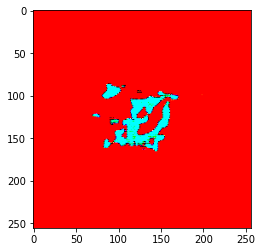

In [24]:
plt.imshow(skimage.transform.rotate(predictions[226,:,:],90))

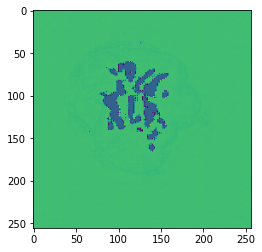

In [13]:
converted = tf.image.rgb_to_grayscale(predictions[326,:,:,:].astype(np.uint8))
plt.imshow(converted)

In [14]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

ValueError: Expected image array to have rank 3 (single image). Got array with shape: (256, 3)

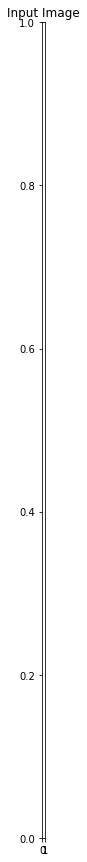

In [15]:
display(predictions[251,:,:])

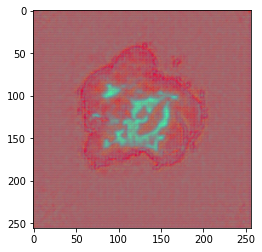

In [23]:
plt.imshow(tf.keras.preprocessing.image.array_to_img(skimage.transform.rotate(predictions[226,:,:],90)))

In [17]:
image = predictions[326,:,:,:].astype(np.uint8).copy()

image1 = rgb2gray(image)
image2 = np.where(image1 <= 0.6, 1, 0)
#     image = rescale(image, (resize1/a_in[:, :, i].shape[1]), preserve_range=True, anti_aliasing=False)
# image2 = (((image1 - image1.min()) / (image1.max() - image1.min())) * 255.9).astype(np.uint8)
image3 = image2 >0
image3 = skimage.morphology.remove_small_objects(image3, 10)
# image3 = skimage.morphology.remove_small_objects(image3, 100)
image3 = skimage.transform.rotate(image3,90)
# image3 = (((image3 - image3.min()) / (image3.max() - image3.min())) * 255.9).astype(np.uint8)

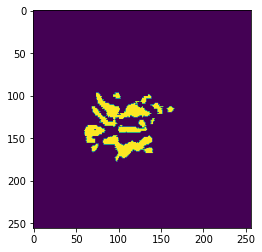

In [18]:
plt.imshow(image3)

In [ ]:
# test
def preprocess_image(file):
    # file is not a tensor, so we have to use functions that work on tensors
    img_string = tf.read_file(file)
    img = tf.image.decode_png(img_string)
    img = tf.image.resize_images(target_size)
    img = vgg16.preprocess_input(img)  # this function can handle tensors as well.
    return img


batch_size = 16
num_threads = 2
target_size=(256, 256)

files = [file1, file2, ...]
dataset = Dataset.from_tensor_slices(tf.constant(files))
dataset = dataset.map(preprocess_image, num_threads)
dataset = dataset.batch(batch_size)
dataset = dataset.prefetch(1)  
predictions = vgg_model.predict(dataset, steps=len(files) // batch_size)
# You could decode the predictions from here :)